In [1]:
import torch
import numpy as np
import os

from misc import *


os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# Check System Devices

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    for d in range(device_count):
        device_name = torch.cuda.get_device_name(d)
        print(device_name)
    #
#

device = torch.device('cuda:0')

Using device: cuda
NVIDIA GeForce RTX 3090


# Autograd Example 1
## - tensor.backward()

In [3]:
#Create tensors
x = torch.tensor(3., requires_grad=True, device=device)
w = torch.tensor(2., requires_grad=True, device=device)
b = torch.tensor(1., requires_grad=True, device=device)

print(x.is_leaf, w.is_leaf, b.is_leaf)

# x = torch.tensor(1., requires_grad=True).to(device)
# w = torch.tensor(2., requires_grad=True).to(device)
# b = torch.tensor(3., requires_grad=True).to(device)

# print(x.is_leaf, w.is_leaf, b.is_leaf)

# Build a computational graph
y = w*x**2 + torch.sqrt(b)         # y = w*x^2 + sqrt(b)

# Compute gradients
y.backward()

# Print out the gradients
print(x.grad, (2*w*x).item())                            # dy/dx = 2*w*x
print(w.grad, (x**2).item())                             # dy/dw = x^2
print(b.grad, (0.5/torch.sqrt(b)).data.cpu().numpy())    # dy/db = (1/2)*(1/sqrt(b))


True True True
tensor(12., device='cuda:0') 12.0
tensor(9., device='cuda:0') 9.0
tensor(0.5000, device='cuda:0') 0.5


# Autograd Example 2
## - torch.autograd.grad() and high-order gradients

In [4]:
#Create tensors
x = torch.tensor(3., requires_grad=True, device=device)
w = torch.tensor(2., requires_grad=True, device=device)
b = torch.tensor(1., requires_grad=True, device=device)

# Build a computational graph
y = w*x**2 + torch.sqrt(b)         # y = w*x^2 + b

# Use autograd to compute the first-order gradient dy/dx
grad_x = torch.autograd.grad(y, x, create_graph=True)    # create_graph
print(grad_x, (2*w*x).item())

# Use autograd to compute the second-order gradient d^2y/dx^2
grad_xx = torch.autograd.grad(grad_x, x)
print(grad_xx, 2*w.item())



(tensor(12., device='cuda:0', grad_fn=<MulBackward0>),) 12.0
(tensor(4., device='cuda:0'),) 4.0


# Autograd Example 3
## - grad of loss fn: A logistic regression example
## - (https://pytorch.org/docs/stable/nn.html#loss-functions)

In [5]:
N = 100  # num of samples
d = 5    # design dimensions
X = torch.randn(N, d).to(device)   # data to device                     
y = torch.empty(N, dtype=torch.long).random_(2).to(device)

w = torch.empty(d, 1, requires_grad=True, device=device)
w = torch.nn.init.normal_(w)  # initialize the weights

yhat = 1/(1+torch.exp(-torch.matmul(X, w)))
yhat = yhat.squeeze() # convert to (N,) row vector

loss = -torch.mean(y*torch.log(yhat) + (1 - y)* torch.log(1-yhat))
loss.backward()
print(w.grad)



tensor([[ 0.1905],
        [-0.3739],
        [-0.0894],
        [ 0.1189],
        [-0.0952]], device='cuda:0')


# Input pipline: Dataset and Dataloader
## - built-in datasets (https://pytorch.org/vision/stable/datasets.html)

torch.Size([6, 1, 28, 28])
tensor([3, 6, 6, 3, 2, 7])


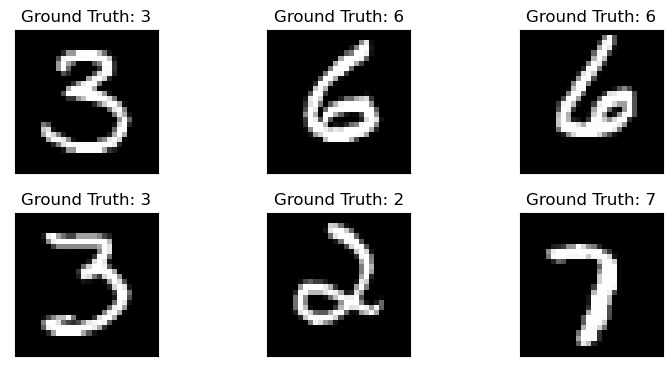

In [6]:
import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

train_dataset = torchvision.datasets.MNIST('data/__cache__', train=True, download=True,
                     transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize(
                         (0.1307,), (0.3081,))
                     ]))

batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

images, labels = next(iter(train_loader))

print(images.shape)
print(labels)

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(batch_size):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])


# Input pipline: Dataset and Dataloader
## - custom datasets

In [7]:
raw_tr = np.loadtxt(os.path.join('data/bank-note', 'train.csv'), delimiter=',')
raw_te = np.loadtxt(os.path.join('data/bank-note', 'test.csv'), delimiter=',')

Xtr, ytr, Xte, yte = raw_tr[:,:-1], raw_tr[:,-1].reshape([-1,1]), raw_te[:,:-1], raw_te[:,-1].reshape([-1,1])

print(Xtr.shape, ytr.shape, Xte.shape, yte.shape)        
        

(872, 4) (872, 1) (500, 4) (500, 1)


In [8]:
class BankNote(Dataset):
    def __init__(self, data_path, mode):
        
        super(BankNote, self).__init__()
        
        # TODO
        # 1. Initialize internal data 
        
        raw_tr = np.loadtxt(os.path.join(data_path, 'train.csv'), delimiter=',')
        raw_te = np.loadtxt(os.path.join(data_path, 'test.csv'), delimiter=',')
        
        Xtr, ytr, Xte, yte = \
            raw_tr[:,:-1], raw_tr[:,-1].reshape([-1,1]), raw_te[:,:-1], raw_te[:,-1].reshape([-1,1])
        
        if mode == 'train':
            self.X, self.y = Xtr, ytr
        elif mode == 'test':
            self.X, self.y = Xte, yte
        else:
            raise Exception("Error: Invalid mode option!")
        
    def __getitem__(self, index):
        
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        
        return self.X[index,:], self.y[index,:]
    
    def __len__(self,):
        # Return total number of samples.
        return self.X.shape[0]
    
    
dataset_train = BankNote('data/bank-note', mode='train')
dataset_test = BankNote('data/bank-note', mode='test')

print(len(dataset_train), len(dataset_test))

train_loader = DataLoader(dataset=dataset_train, batch_size=128, shuffle=True, drop_last=False)

epochs=2

for ie in range(epochs):
    cprint('r', 'Epoch {}'.format(ie))
    for batch_idx, (X, y) in enumerate(train_loader):
        print('batch_{}, {}, {}'.format(batch_idx, X.shape, y.shape))
    #
#

872 500
Epoch 0
batch_0, torch.Size([128, 4]), torch.Size([128, 1])
batch_1, torch.Size([128, 4]), torch.Size([128, 1])
batch_2, torch.Size([128, 4]), torch.Size([128, 1])
batch_3, torch.Size([128, 4]), torch.Size([128, 1])
batch_4, torch.Size([128, 4]), torch.Size([128, 1])
batch_5, torch.Size([128, 4]), torch.Size([128, 1])
batch_6, torch.Size([104, 4]), torch.Size([104, 1])
Epoch 1
batch_0, torch.Size([128, 4]), torch.Size([128, 1])
batch_1, torch.Size([128, 4]), torch.Size([128, 1])
batch_2, torch.Size([128, 4]), torch.Size([128, 1])
batch_3, torch.Size([128, 4]), torch.Size([128, 1])
batch_4, torch.Size([128, 4]), torch.Size([128, 1])
batch_5, torch.Size([128, 4]), torch.Size([128, 1])
batch_6, torch.Size([104, 4]), torch.Size([104, 1])
